In [14]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import os
import random

from functions.parse_data import synth_dataloader
from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from cot_train.utils import MLP5

In [15]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)
device = tensor.device

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [16]:
#Load data and inspect
df = synth_dataloader('SMHIdata')
df.head(10)

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B08A,Cloud_B09,Cloud_B10,...,Clear_B11,Clear_B12,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor
0,0.94195,0.87799,0.92936,0.93407,0.95181,0.96217,0.92871,0.97181,0.49957,0.04136,...,0.12946,0.18888,4.53,52.05,167.66,5.897,3,3335,0.126,0.35
1,0.30422,0.40100,0.27834,0.57800,1.01964,1.02787,1.00519,1.03599,0.59139,0.01055,...,0.71532,0.36823,12.85,41.68,161.91,1.275,2,1996,0.126,0.31
2,0.28715,0.25066,0.30366,0.29214,0.34088,0.40079,0.37376,0.48750,0.02092,0.00067,...,0.86232,0.63915,14.53,79.23,168.52,1.799,1,6796,0.127,4.04
3,0.27146,0.33719,0.19841,0.46411,0.88787,0.89584,0.87746,0.90439,0.51811,0.00561,...,0.56307,0.23663,6.54,70.23,165.49,0.519,2,3701,0.123,0.22
4,0.39689,0.38594,0.32623,0.37338,0.60678,0.66895,0.55343,0.70168,0.01513,0.00049,...,0.56472,0.20853,8.56,75.15,148.48,8.569,2,6345,0.128,5.40
5,0.75592,0.65853,0.70670,0.71369,0.73147,0.74182,0.71190,0.75003,0.32287,0.00328,...,0.92187,0.87515,12.38,73.72,153.05,16.874,3,1419,0.126,0.51
6,0.34660,0.30719,0.27459,0.35268,0.72965,0.74705,0.69842,0.75893,0.18345,0.00089,...,0.64499,0.27212,14.74,73.05,13.63,3.589,3,424,0.122,0.99
7,0.22494,0.33843,0.19615,0.53821,0.98347,0.99256,0.96757,1.00132,0.53669,0.00511,...,0.61388,0.28605,8.24,53.20,146.76,0.624,2,3427,0.125,0.35
8,0.57982,0.62369,0.57909,0.75147,0.99608,1.04055,0.94017,1.07212,0.43014,0.03328,...,0.94942,0.49475,11.57,38.00,117.48,13.909,1,6884,0.122,1.88
9,0.83664,0.80620,0.81432,0.78581,0.81063,0.84108,0.78542,0.85153,0.26374,0.00122,...,0.90206,0.89850,9.69,45.83,23.04,24.937,3,7455,0.106,1.77


In [17]:
#Set columns for X and y (input/output features)
X_cols = ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
          'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Sun_Zenith_Angle']
y_cols = ['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
          'Clear_B07','Clear_B08','Clear_B08A','Clear_B09','Clear_B10','Clear_B11','Clear_B12']

#Find X and y
X=df[X_cols]
y=df[y_cols]


In [18]:
#Set up paths for importing COT est models
COT_model_paths = ['smhi_models3/0/model_it_2000000','smhi_models3/1/model_it_2000000','smhi_models3/2/model_it_2000000','smhi_models3/3/model_it_2000000','smhi_models3/4/model_it_2000000',
                   'smhi_models3/5/model_it_2000000','smhi_models3/6/model_it_2000000','smhi_models3/7/model_it_2000000','smhi_models3/8/model_it_2000000','smhi_models3/9/model_it_2000000']

#Initialize and load COT estimation models
COT_est_models = [MLP5(13, 1, apply_relu=True) for _ in range(len(COT_model_paths))]
for i,model in enumerate(COT_est_models):
    model.load_state_dict(torch.load(COT_model_paths[i],map_location=device))

#Create X for COT estimation
X_COTest = X.to_numpy()
#Add noise for fairness
X_COTest= X_COTest + np.random.randn(np.shape(X_COTest)[0],np.shape(X_COTest)[1]) * np.mean(X_COTest,axis=0)*0.03
#Normalize and turn into tensor before input
X_COTest_mu = np.mean(X_COTest,axis=0)
X_COTest_std = np.std(X_COTest,axis=0)
X_COTest_norm = (X_COTest-X_COTest_mu)/X_COTest_std
tX_COTest_norm = torch.Tensor(X_COTest_norm).to(device)
#Make predictions (*50 to denormalize predictions)
COT_preds_total = []
for i,model in enumerate(COT_est_models):
    COT_preds = 50*model(tX_COTest_norm).cpu().detach().numpy()
    #Keep track of ensemble prediction
    if i==0:
        COT_preds_total=COT_preds
    else:
        COT_preds_total=COT_preds_total+COT_preds

COT_preds_total = COT_preds_total/len(COT_est_models)

#Sort into categories instead
t_is_cloud = 0.025*50 #From Pirinen et. al.
t_thin_cloud = 0.015*50 #From Pirinen et. al.

pred_clear = np.zeros(COT_preds_total.shape)
pred_thin = np.zeros(COT_preds_total.shape)
pred_thick = np.zeros(COT_preds_total.shape)

pred_clear[COT_preds_total<t_thin_cloud]=1
pred_thin[(COT_preds_total>=t_thin_cloud)&(COT_preds_total<t_is_cloud)]=1
pred_thick[COT_preds_total>=t_is_cloud]=1

#Create new X including COT dummies
X = X.assign(Clear=pred_clear[:,0])
X = X.assign(Thin=pred_thin[:,0])
X = X.assign(Thick=pred_thick[:,0])

#Update X_cols
X_cols = ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
          'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12',
          'Sun_Zenith_Angle','Clear','Thin','Thick']

#Separate testdata from rest for 80/10/10 Train/Val/Test split
X_trainval, X_test, y_trainval, y_test=train_test_split(X,y,test_size=0.1,random_state=313)

#Find clear indices in trainval
clear_indices = np.array([])
for i,df_idx in enumerate(X_trainval.index):
    if df['Cloud_Type'][df_idx]==0:
        clear_indices=np.append(clear_indices,i)

#Add noise to X_test, 0 mean with stdev equal to 3% of mean of each feature
np.random.seed(313)
X_test.iloc[:,:13] = X_test.iloc[:,:13] + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]-3) * np.mean(X.iloc[:,:13].to_numpy(),axis=0)*0.03

In [19]:
#Choose if to save models and data, if so set path
save = True
if save:
    test_name = "Final_model_no_clear_noise"
    main_filepath = 'pytorch_models/'+test_name

#Set up which quantiles to estimate, and find index of estimator (q=0.5)
quantiles=np.array([0.1,0.5,0.9])
est= np.where(quantiles==0.5)[0].item()

#Set up algorithm parameters
val_size=0.1
num_models=10
batch_size=500
nepochs=1000
lr=0.002
noise_ratio = 0.03
early_break=True
no_nodes = 200
clear_noise=False

#Create network
sequence= lambda: nn.Sequential(
    nn.Linear(len(X_cols),no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes, len(quantiles)*len(y_cols)) #Output dimesion is number of quantiles times number of target variables
)

#Initalize models
models = [QuantileNetwork(quantiles=quantiles) for _ in range(num_models)]

#Train models
for i,model in enumerate(models):
    #Find new train/val splits for each model for robustness
    validation_indices=np.array(random.sample(range(len(X_trainval['Cloud_B02'])), int(len(X['Cloud_B02'])*val_size)))
    train_indices=[i for i in range(len(X_trainval['Cloud_B02'])) if np.any(validation_indices==i)==False]  
    #Fit model with X
    model.fit(X_trainval.to_numpy(),y_trainval.to_numpy(), 
            train_indices=train_indices, 
            validation_indices=validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence(),
            lr=lr,
            noise_ratio=noise_ratio,
            early_break=early_break,
            clear_noise=clear_noise,
            clear_indices=clear_indices)
    
    #Save models if wanted
    if save:
        filepath=main_filepath+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')

#Finally save data if wanted
if save: 
    filepath=main_filepath+'/data'
    os.makedirs(filepath,exist_ok=True)
    #Save datasplits
    X_trainval.to_csv(filepath+'/X_trainval.csv')
    y_trainval.to_csv(filepath+'/y_trainval.csv')
    X_test.to_csv(filepath+'/X_test.csv')
    y_test.to_csv(filepath+'/y_test.csv')

Epoch 641


Batch number: 100%|██████████| 320/320 [00:01<00:00, 313.06it/s]

Training loss [1.9872453] Validation loss [2.0205064]
Epoch 642



Batch number: 100%|██████████| 320/320 [00:01<00:00, 313.08it/s]

Training loss [1.974375] Validation loss [1.9957867]
Epoch 643



Batch number: 100%|██████████| 320/320 [00:01<00:00, 313.14it/s]

Training loss [1.9731247] Validation loss [2.034162]
Epoch 644



Batch number: 100%|██████████| 320/320 [00:01<00:00, 312.59it/s]

Training loss [1.9740248] Validation loss [2.021884]
Epoch 645



Batch number: 100%|██████████| 320/320 [00:01<00:00, 313.25it/s]

Training loss [1.9830414] Validation loss [2.0046413]
Epoch 646



Batch number: 100%|██████████| 320/320 [00:01<00:00, 313.08it/s]

Training loss [1.9755609] Validation loss [2.0137758]
Epoch 647



Batch number: 100%|██████████| 320/320 [00:01<00:00, 313.25it/s]

Training loss [1.9767845] Validation loss [2.0174832]
Epoch 648



Batch number: 100%|██████████| 320/320 [00:01<00:00, 312.35it/s]

Training loss [1.9747578] Validation loss [2.0230026]
Epoch 649



Batch number: 100%|██████████| 320/320 [00:01<00:00, 313.61it/s]

Training loss [1.9805505] Validation loss [2.026947]


---No improvement in 100 epochs, broke early---
Best model out of total max epochs found at epoch 549
With validation loss: 1.994097352027893


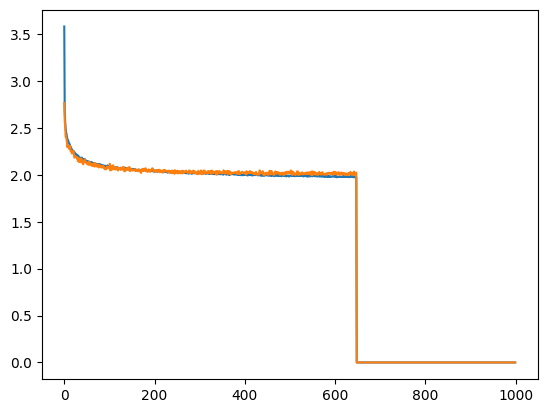

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(model.train_loss.cpu())
plt.plot(model.val_loss.cpu())
plt.show()

In [21]:
X.iloc[:,:13]

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B08A,Cloud_B09,Cloud_B10,Cloud_B11,Cloud_B12,Sun_Zenith_Angle
0,0.94195,0.87799,0.92936,0.93407,0.95181,0.96217,0.92871,0.97181,0.49957,0.04136,0.35377,0.36916,52.05
1,0.30422,0.40100,0.27834,0.57800,1.01964,1.02787,1.00519,1.03599,0.59139,0.01055,0.70143,0.34977,41.68
2,0.28715,0.25066,0.30366,0.29214,0.34088,0.40079,0.37376,0.48750,0.02092,0.00067,0.58199,0.42420,79.23
3,0.27146,0.33719,0.19841,0.46411,0.88787,0.89584,0.87746,0.90439,0.51811,0.00561,0.49281,0.20686,70.23
4,0.39689,0.38594,0.32623,0.37338,0.60678,0.66895,0.55343,0.70168,0.01513,0.00049,0.36782,0.18918,75.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.34326,0.33065,0.30906,0.54799,0.69691,0.70308,0.69751,0.71081,0.51136,0.05396,0.21610,0.17078,83.09
199996,0.67538,0.60192,0.63624,0.64307,0.71627,0.72744,0.68661,0.73124,0.29566,0.00216,0.52698,0.45051,71.47
199997,0.80019,0.76760,0.78372,0.82218,0.97845,0.98619,0.94268,0.98844,0.79426,0.31875,0.13701,0.16162,44.88
199998,0.80365,0.71523,0.77816,0.80325,0.81675,0.82206,0.81107,0.82767,0.60124,0.11536,0.12915,0.16530,74.68
